# 🤖 Building a Self-Improving Report Writer with LangGraph

## What You'll Learn in This Tutorial

In this notebook, we'll build an AI-powered report writing system that can:
1. **Generate** an initial report based on a topic you provide
2. **Review** the report and give itself constructive feedback
3. **Improve** the report by incorporating that feedback

This is called a **"reflection loop"** — the AI reflects on its own work and makes it better!

### Why is This Useful?
Just like how a student writes a first draft, gets feedback from a teacher, and then revises their work — our AI will do the same thing automatically!

---

## 📦 Section 1: Installation

Before we begin, we need to install some Python packages (libraries) that our code will use.

**Note:** If you've already installed these, you can skip this cell. The `#` at the start means this line is "commented out" and won't run automatically.


In [ ]:
# ============================================================
# 📦 INSTALL REQUIRED PACKAGES
# ============================================================
# Uncomment the line below (remove the #) to install packages
# You only need to do this once!

!pip install langchain_openai langchain_community langgraph langchain_tavily

---

## 📚 Section 2: Importing Libraries

Now we need to import the tools (libraries) we'll use to build our AI system.

**Think of imports like gathering your supplies before starting a project:**
- `ChatOpenAI` — Lets us talk to OpenAI's GPT models (the AI brain)
- `ChatPromptTemplate` — Helps us create instructions for the AI
- `StateGraph` — Helps us build a "workflow" that the AI follows step-by-step
- `MemorySaver` — Allows the AI to remember previous conversations

In [ ]:
# ============================================================
# 📚 IMPORT ALL THE TOOLS WE NEED
# ============================================================

# --- OpenAI Integration ---
# ChatOpenAI: This connects us to OpenAI's powerful language models (like GPT-4)
from langchain_openai import ChatOpenAI

# --- Prompt Building Tools ---
# ChatPromptTemplate: Helps us create structured instructions for the AI
# MessagesPlaceholder: A placeholder where conversation history gets inserted
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# --- Message Types ---
# AIMessage: Messages that come FROM the AI
# HumanMessage: Messages that come FROM the user (or simulated as feedback)
from langchain_core.messages import AIMessage, HumanMessage

# --- LangGraph: Building the AI Workflow ---
# StateGraph: The main tool to create a step-by-step workflow
# START: Where our workflow begins
# END: Where our workflow finishes
from langgraph.graph import StateGraph, START, END

# add_messages: A special function that helps manage conversation history
from langgraph.graph.message import add_messages

# MemorySaver: Allows the AI to remember what happened in the conversation
from langgraph.checkpoint.memory import MemorySaver

# --- Python Type Hints ---
# These help us define what kind of data our variables should hold
# (Don't worry too much about these — they make the code cleaner and safer)
from typing import Annotated, List
from typing_extensions import TypedDict



---

## 🔑 Section 3: Setting Up API Keys

To use OpenAI's AI models, we need an **API key** — think of it like a password that proves we're allowed to use their services.

**⚠️ Important Security Note:**
- Never share your API keys publicly!
- In real projects, store keys in environment variables or secure vaults
- The keys below are shown partially hidden for security

In [ ]:
# ============================================================
# 🔑 SET UP YOUR API KEYS
# ============================================================

from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
print(api_key[:5] + "*****")



tavily_api_key = userdata.get('TAVILY_API_KEY')
print(tavily_api_key[:5] + "*****")

sk-pr*****
tvly-*****


---

## 🧠 Section 4: Creating the AI Models

We'll use **two different AI models** for our system:

1. **Generator Model (GPT-4o-mini)**: A faster, lighter model that writes the initial report
2. **Reflection Model (GPT-4o)**: A more powerful model that reviews and provides feedback

### Why use two models?
- The generator is faster and cheaper for the bulk writing work
- The reviewer is smarter and can catch issues the generator might miss
- This mimics having a writer and an editor working together!

In [ ]:
# ============================================================
# 🖊️ CREATE THE GENERATOR MODEL (The Writer)
# ============================================================
# This model will be responsible for WRITING the reports
# We use "gpt-4o-mini" because it's fast and good at generating content

generator_model = ChatOpenAI(
    model_name="gpt-4o-mini",   # The specific AI model to use
    openai_api_key=api_key      # Our API key to authenticate
)

In [ ]:
# ============================================================
# 🔍 CREATE THE REFLECTION MODEL (The Reviewer/Editor)
# ============================================================
# This model will be responsible for REVIEWING the reports and giving feedback
# We use "gpt-4o" (the full version) because it's better at critical analysis

reflection_model = ChatOpenAI(
    model_name="gpt-4o",        # More powerful model for better reviews
    openai_api_key=api_key      # Our API key to authenticate
)

---

## 📝 Section 5: Creating Prompt Templates

A **prompt template** is like a script or set of instructions we give to the AI. It tells the AI:
- What role it should play (e.g., "You are an expert report writer")
- What it should do with the user's input
- How it should behave

### What is a "System Message"?
The system message sets the AI's personality and behavior. It's like giving an actor their character description before they perform!

In [ ]:
# ============================================================
# 📝 PROMPT TEMPLATE FOR THE GENERATOR (Report Writer)
# ============================================================

# Create the instructions for our report-writing AI
generator_prompt = ChatPromptTemplate.from_messages(
    [
        # --- The System Message ---
        # This tells the AI WHO it is and HOW it should behave
        (
            "system",
            "You are an expert report writer. You write comprehensive and informative reports. "
            "Generate a detailed report based on user input. "
            "If you receive feedback from a reviewer, carefully incorporate that feedback "
            "to improve and rewrite your report."
        ),

        # --- The Messages Placeholder ---
        # This is where the conversation history will be inserted
        # It includes: the user's topic AND any previous feedback
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# ============================================================
# 🔗 COMBINE THE PROMPT WITH THE MODEL
# ============================================================
# The "|" symbol creates a "chain" — the prompt feeds into the model
# Think of it like a pipeline: Prompt → Model → Response

generator_report = generator_prompt | generator_model

In [ ]:
# ============================================================
# 📝 PROMPT TEMPLATE FOR THE REFLECTION MODEL (Report Reviewer)
# ============================================================

# Note: We import again here in case you run cells out of order
# (This is a common practice in notebooks to make cells more independent)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Create the instructions for our report-reviewing AI
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        # --- The System Message ---
        # This tells the AI to act as a critical reviewer
        (
            "system",
            "You are an expert report reviewer and you provide best detailed feedback on the reports. "
            "Analyse the report for content depth, accuracy and structure. "
            "Provide constructive feedback and suggestions for improvement."
        ),

        # --- The Messages Placeholder ---
        # This is where the report (and conversation history) will be inserted
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# ============================================================
# 🔗 COMBINE THE REFLECTION PROMPT WITH THE MODEL
# ============================================================
# Create a chain: Reflection Prompt → Reflection Model → Feedback

reflection_chain = reflection_prompt | reflection_model

---

## 🏗️ Section 6: Defining the State

In LangGraph, the **State** is like a shared notebook that all parts of our system can read and write to.

### What goes in our State?
1. **messages**: The conversation history (user input, AI responses, feedback)
2. **iteration**: A counter to track how many times we've generated/improved the report

### Why do we need State?
- It lets us pass information between different steps of our workflow
- It helps us track progress (are we on the first draft or the improved version?)
- It stores the conversation so the AI can "remember" what happened before

In [ ]:
# ============================================================
# 🏗️ DEFINE THE STATE (The Shared Memory of Our System)
# ============================================================

class State(TypedDict):
    """
    This class defines what information our system will track and share.
    Think of it as a form with fields that get filled in as the system runs.
    """

    # Field 1: messages
    # Stores the entire conversation history (user input, AI responses, feedback)
    # The "Annotated[list, add_messages]" part tells LangGraph to automatically
    # combine new messages with old ones (instead of replacing them)
    messages: Annotated[list, add_messages]

    # Field 2: iteration
    # A simple counter to track which round of writing we're on
    # iteration=1 means first draft, iteration=2 means improved version
    iteration: int


---

## 🔄 Section 7: Building the Graph (The Workflow)

Now we'll create the **StateGraph** — this is like drawing a flowchart for our AI system.

### Our Workflow Has These Steps:
```
START → Generate Report → Review Report → Generate Again (improved) → END
```

### Key Concepts:
- **Nodes**: The "boxes" in our flowchart — each node does one job
- **Edges**: The "arrows" that connect nodes — they control the flow
- **Conditional Edges**: Smart arrows that decide where to go based on conditions

In [ ]:
# ============================================================
# 🔄 CREATE THE GRAPH BUILDER
# ============================================================
# This is our "canvas" where we'll draw the workflow
# We pass in our State class so the graph knows what data to track

builder = StateGraph(State)

### 📦 Node 1: The Report Generator

This node calls our generator model to write (or rewrite) the report.

**What it does:**
1. Gets the current iteration count
2. Asks the AI to generate a report based on the messages so far
3. Increments the iteration counter
4. Returns the new state with the generated report

In [ ]:
# ============================================================
# 📦 NODE 1: THE REPORT GENERATOR
# ============================================================

async def report_generator(state: State) -> State:
    """
    This function generates (or regenerates) the report.

    Parameters:
        state: The current state containing messages and iteration count

    Returns:
        Updated state with the new report added to messages
    """

    # Step 1: Get the current iteration count
    # If this is the first time, default to 0
    current_iteration = state.get("iteration", 0)

    # Step 2: Call the AI to generate a report
    # "ainvoke" is the async version of "invoke" — it runs without blocking
    # We pass in all the messages (including any feedback from previous rounds)
    generated_message = await generator_report.ainvoke({"messages": state["messages"]})

    # Step 3: Format the response properly
    # This ensures the AI's response is in a consistent format (list of content blocks)
    if isinstance(generated_message.content, str):
        generated_message.content = [{"type": "text", "text": generated_message.content}]

    # Step 4: Return the updated state
    # We add the generated report to messages and increment the iteration counter
    return {
        "messages": [generated_message],
        "iteration": current_iteration + 1  # Now we're on the next iteration
    }

# ============================================================
# ADD THE GENERATOR NODE TO OUR GRAPH
# ============================================================
# "generate" is the name we give this node — we'll use it when connecting nodes

builder.add_node("generate", report_generator)

### 📦 Node 2: The Report Reviewer (Reflection)

This node reviews the generated report and provides constructive feedback.

**What it does:**
1. Takes the current report from the messages
2. Asks the reviewer AI to analyze and critique it
3. Wraps the feedback as a "human message" (so the generator treats it as input)
4. Returns the feedback so the generator can use it to improve

In [ ]:
# ============================================================
# 📦 NODE 2: THE REPORT REVIEWER (REFLECTION)
# ============================================================

async def reflection_report(state: State) -> State:
    """
    This function reviews the generated report and provides feedback.

    Parameters:
        state: The current state containing the report in messages

    Returns:
        Updated state with reviewer feedback added to messages
    """

    # Step 1: Send the entire conversation history to the reviewer
    # This includes the original topic AND the generated report
    res = await reflection_chain.ainvoke({"messages": state["messages"]})

    # Step 2: Extract the feedback text from the response
    # The AI can return content in different formats, so we handle both
    if isinstance(res.content, str):
        # If it's a simple string, use it directly
        feedback_content = res.content
    else:
        # If it's a list of content blocks, get the text from the first one
        feedback_content = res.content[0]["text"] if res.content else ""

    # Step 3: Wrap the feedback as a "HumanMessage"
    # Why? Because the generator expects input from a "human" (user)
    # By labeling it as feedback, the generator knows to incorporate it
    feedback_message = HumanMessage(content=[{
        "type": "text",
        "text": f"[REVIEWER FEEDBACK]: {feedback_content}\n\nPlease rewrite and improve your report based on this feedback."
    }])

    # Step 4: Return the updated state with the feedback added
    return {"messages": [feedback_message]}

# ============================================================
# ADD THE REFLECTION NODE TO OUR GRAPH
# ============================================================

builder.add_node("reflection", reflection_report)

### 🔗 Connecting the Nodes with Edges

Now we need to connect our nodes (boxes) with edges (arrows) to create the complete workflow.

**Our Flow:**
1. **START → generate**: Begin by generating the first draft
2. **generate → reflection OR END**: After generating, either get feedback or finish
3. **reflection → generate**: After reviewing, go back to generate an improved version

In [ ]:
# ============================================================
# 🔗 EDGE 1: START → GENERATE
# ============================================================
# This tells the graph: "When the workflow starts, go to the generate node first"

builder.add_edge(START, "generate")


In [ ]:
# ============================================================
# ⚙️ CONFIGURATION: HOW MANY ITERATIONS?
# ============================================================
# This controls how many times the report gets written
# MAX_ITERATIONS = 2 means: generate once, get feedback, then generate again

MAX_ITERATIONS = 2

# ============================================================
# 🔀 CONDITIONAL EDGE: SHOULD WE CONTINUE OR END?
# ============================================================
# After generating, we need to decide: Should we get feedback or are we done?
# This function makes that decision based on how many iterations we've done

def should_continue(state: State):
    """
    Decide whether to continue to reflection or end the workflow.

    Returns:
        "continue" - if we haven't reached the max iterations (go get feedback)
        "end" - if we've done enough iterations (output the final report)
    """
    # Get the current iteration count
    current_iteration = state.get("iteration", 0)

    # Make the decision based on iteration count
    if current_iteration < MAX_ITERATIONS:
        # We haven't reached the limit yet — let's get feedback!
        return "continue"
    else:
        # We've done enough iterations — output the final report
        return "end"

# ============================================================
# 🔗 EDGE 2: GENERATE → (REFLECTION or END)
# ============================================================
# This is a "conditional edge" — it can go to different places based on a condition
# The path_map translates the function's return values to actual destinations

builder.add_conditional_edges(
    "generate",                    # From this node...
    should_continue,               # Use this function to decide...
    {
        "continue": "reflection",  # If "continue" → go to reflection node
        "end": END                 # If "end" → finish the workflow
    }
)

# ============================================================
# 🔗 EDGE 3: REFLECTION → GENERATE
# ============================================================
# After getting feedback, ALWAYS go back to generate to rewrite the report
# This creates the "feedback loop" that improves the report

builder.add_edge("reflection", "generate")

---

## 🎯 Section 8: Compiling the Graph

Now that we've defined all the nodes and edges, we need to "compile" the graph.

**What does compiling do?**
- It validates that all nodes are connected properly
- It prepares the graph to actually run
- It adds memory (checkpointing) so the AI can remember conversation history

In [ ]:
# ============================================================
# 🎯 COMPILE THE GRAPH
# ============================================================

# Step 1: Create a memory saver
# This allows the AI to remember previous messages in the conversation
# It's like giving the AI a notebook to take notes
memory = MemorySaver()

# Step 2: Compile the graph
# This finalizes our workflow and makes it ready to run
# The "checkpointer" parameter enables conversation memory
graph = builder.compile(checkpointer=memory)

# Success! Our workflow is ready to use

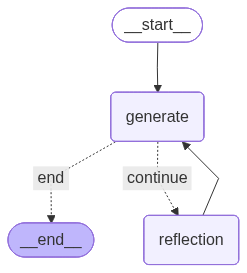

In [ ]:
# ============================================================
# 👀 INSPECT THE GRAPH OBJECT
# ============================================================
# Running this cell shows information about our compiled graph
# It confirms our workflow was created successfully

graph

### 📊 Visualizing the Workflow

Let's draw a picture of our workflow! This helps us understand the flow at a glance.

You should see a flowchart that looks like:
```
START → generate ⟷ reflection → END
```

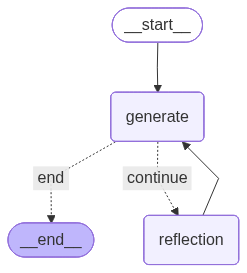

In [ ]:
# ============================================================
# 📊 DRAW THE WORKFLOW DIAGRAM
# ============================================================
# This creates a visual flowchart of our graph
# It uses Mermaid (a diagram tool) to draw the picture

from IPython.display import display, Image

# Get the graph structure and convert it to an image
# This helps us visually verify our workflow is correct
display(Image(graph.get_graph().draw_mermaid_png()))

---

## 🚀 Section 9: Running the Agent

It's time to see our self-improving report writer in action!

### What Will Happen:
1. We provide a **topic** (e.g., "National Animal Of India")
2. The AI **generates** a first draft
3. The reviewer AI **analyzes** the draft and provides feedback
4. The generator AI **rewrites** the report incorporating the feedback
5. We see the **first draft**, **feedback**, and **final improved report**

In [ ]:
# ============================================================
# ⚙️ CONFIGURATION: SET UP THE RUN
# ============================================================

import uuid

# Step 1: Create a unique thread ID
# Each conversation needs a unique ID so the AI can keep track of different chats
# uuid.uuid4() generates a random unique identifier
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Step 2: Choose your topic!
# Change this to any topic you want a report about
# Examples: "Climate Change", "History of the Internet", "Artificial Intelligence"
topic = "National Animal Of India"

print(f"📋 Topic selected: {topic}")
print(f"🆔 Session ID: {config['configurable']['thread_id'][:8]}...")

📋 Topic selected: National Animal Of India
🆔 Session ID: a504b5d6...


In [ ]:
# ============================================================
# 🚀 RUN THE SELF-IMPROVING REPORT WRITER
# ============================================================

# Import tools for displaying formatted output
from IPython.display import display, Markdown


# ============================================================
# 🛠️ HELPER FUNCTIONS
# ============================================================
# We create small, reusable functions to keep our code clean
# Each function does ONE specific job — this makes code easier to read!

def display_section(title: str, emoji: str, content: str | None):
    """
    Display a section with a nice header and formatted content.

    Parameters:
        title: The section heading (e.g., "FIRST DRAFT")
        emoji: An emoji to make it visually appealing
        content: The text to display (or None if not available)
    """
    print("=" * 70)
    print(f"{emoji} {title}")
    print("=" * 70)

    if content:
        display(Markdown(content))
    else:
        print(f"No {title.lower()} generated")

    print()  # Add spacing after each section




In [ ]:
def extract_text_from_message(message) -> str:
    """
    Safely extract text content from an AI message.

    Messages can come in different formats, so this function
    handles both simple strings and structured content blocks.

    Parameters:
        message: The AI message object

    Returns:
        The text content as a string
    """
    content = message.content

    # If it's already a string, return it
    if isinstance(content, str):
        return content

    # If it's a list of content blocks, get the first text block
    if isinstance(content, list) and len(content) > 0:
        return content[0].get("text", "")

    return ""




In [ ]:
def clean_feedback_text(feedback: str) -> str:
    """
    Remove the wrapper text we added when passing feedback to the generator.

    We added "[REVIEWER FEEDBACK]:" prefix and instructions —
    this function strips those out for cleaner display.

    Parameters:
        feedback: The raw feedback text with our wrapper

    Returns:
        Clean feedback text without the wrapper
    """
    # Remove the prefix we added
    if feedback.startswith("[REVIEWER FEEDBACK]:"):
        feedback = feedback.replace("[REVIEWER FEEDBACK]: ", "")

    # Remove the instruction we appended
    feedback = feedback.replace(
        "\n\nPlease rewrite and improve your report based on this feedback.",
        ""
    )

    return feedback




In [ ]:
# ============================================================
# 🎯 MAIN AGENT FUNCTION
# ============================================================

async def run_agent():
    """
    Run the complete report-writing workflow and display results.

    This function:
    1. Streams events from our graph as they happen
    2. Captures outputs from each step (generate, reflect)
    3. Displays all outputs in a nicely formatted way
    """

    # Initialize containers for our outputs
    first_draft = None      # The initial report
    review_comment = None   # The reviewer's feedback
    final_output = None     # The improved report

    # --------------------------------------------------
    # Run the workflow and capture outputs
    # --------------------------------------------------
    # "astream" runs the graph asynchronously, yielding events
    # as each node completes — perfect for watching progress!

    initial_state = {
        "messages": [HumanMessage(content=[{"type": "text", "text": topic}])],
        "iteration": 0
    }

    async for event in graph.astream(initial_state, config):

        # Handle generator node completion
        if "generate" in event:
            iteration = event["generate"].get("iteration", 0)
            message = event["generate"]["messages"][-1]
            content = extract_text_from_message(message)

            # First iteration = first draft, otherwise = final output
            if iteration == 1:
                first_draft = content
            else:
                final_output = content

        # Handle reflection node completion
        elif "reflection" in event:
            message = event["reflection"]["messages"][-1]
            feedback = extract_text_from_message(message)
            review_comment = clean_feedback_text(feedback)

    # --------------------------------------------------
    # Display all collected outputs
    # --------------------------------------------------
    display_section("FIRST DRAFT", "📝", first_draft)
    display_section("REVIEW COMMENT", "🔍", review_comment)
    display_section("FINAL OUTPUT (After incorporating feedback)", "✅", final_output)


# ============================================================
# 🎬 START THE WORKFLOW!
# ============================================================
# The "await" keyword runs our async function
# This kicks off the entire report generation process!

await run_agent()

📝 FIRST DRAFT


# Comprehensive Report on the National Animal of India: The Bengal Tiger

## Introduction

The Bengal tiger (Panthera tigris tigris) serves as the National Animal of India. Recognized for its striking beauty, cultural significance, and ecological importance, the Bengal tiger plays a crucial role in India’s identity. This report aims to provide a detailed overview of the Bengal tiger, including its biology, habitat, role in mythology, and conservation status.

## Characteristics

### Physical Attributes
The Bengal tiger is the largest subspecies of tiger, characterized by its distinctive orange coat with black stripes. Males typically weigh between 180 to 250 pounds and measure 8 to 10 feet in length from head to tail. Females are slightly smaller, weighing around 100 to 150 pounds. The tiger's white underbelly and the pattern of its stripes, unique to each individual, serve as both camouflage and a mark of identity.

### Behavior and Diet
Bengal tigers are solitary creatures. They are territorial and mark their dominance through vocalizations, scent markings, and scratch marks on trees. Their diet primarily consists of large prey such as deer, wild boars, and sometimes smaller animals. The hunting strategy often involves stalking and ambush, exploiting their powerful limbs and sharp claws to capture prey.

## Habitat

### Geographic Distribution
The Bengal tiger primarily inhabits the Indian subcontinent, with significant populations found in India. Key regions include:

- The Sundarbans mangrove forests
- Terai grasslands and wetlands
- National parks such as Ranthambore, Kanha, and Bandhavgarh

### Conservation Areas
India has established numerous wildlife sanctuaries and national parks to protect the Bengal tiger's habitat. The Project Tiger initiative, launched in 1973, was instrumental in establishing reserves and providing protection to this iconic species.

## Cultural Significance

The Bengal tiger holds considerable importance in Indian culture, symbolizing grace, power, and beauty. It features prominently in literature, art, and folklore. The tiger is often depicted in Hindu mythology, representing the goddess Durga, who rides a tiger or lion into battle. The animal's representation extends beyond religion and enters the realm of national pride, reflecting strength and resilience.

## Conservation Status

### Threats
Despite its status as a national symbol, the Bengal tiger is classified as endangered by the International Union for Conservation of Nature (IUCN). Major threats include:

- Habitat loss due to deforestation and human encroachment
- Poaching for its fur and body parts
- Decreasing prey availability due to overhunting of species it feeds upon

### Conservation Efforts
A combination of governmental and non-governmental initiatives are underway to conserve the Bengal tiger population, including:

1. **Habitat Restoration**: Efforts to restore and maintain tiger habitats through reforestation and establishing wildlife corridors.
2. **Anti-Poaching Measures**: Strict law enforcement to combat poaching, including the establishment of specialized task forces.
3. **Public Awareness Campaigns**: Educating communities about the ecological importance of tigers and encouraging participation in conservation efforts.
4. **Research and Monitoring**: Continued research on tiger populations and movements to help in effective management and conservation strategies.

## Conclusion

The Bengal tiger, as India’s national animal, represents more than just a species; it embodies the nation's wildlife heritage and commitment to conservation. While significant strides have been made to protect this majestic creature, enduring challenges remain. Collective efforts from the government, NGOs, and communities are vital to ensure that future generations inherit a thriving population of Bengal tigers. Conservation of this iconic animal is not only critical for ecological balance but also for preserving India’s cultural and natural legacy.

## References
- International Union for Conservation of Nature (IUCN)
- National Tiger Conservation Authority (NTCA), India
- Various wildlife journals and publications dedicated to the study and conservation of tigers and their habitats.

---

This report provides a comprehensive overview of the Bengal tiger, considering its biological characteristics, habitat, cultural significance, and conservation measures. For further improvements or specific areas to elaborate on, reviewers are invited to provide feedback.


🔍 REVIEW COMMENT


### Feedback on the Report: National Animal of India - The Bengal Tiger

#### Content Depth
The report offers a well-rounded and detailed examination of the Bengal tiger as India's national animal. Key areas such as physical characteristics, behavior, habitat, cultural significance, and conservation efforts are explored adequately. However, here are a few suggestions to deepen the content further:

1. **Historical Perspective**: Include a brief historical overview of how and why the Bengal tiger was designated as the national animal of India. This could provide readers with historical context and relevance.

2. **Specific Conservation Case Studies**: Including one or two successful case studies where particular conservation efforts showed measurable success could give more depth and context to conservation efforts.

3. **Technological Advances in Conservation**: Explore how modern technology like tracking devices, camera traps, and data analytics are being utilized in tiger conservation.

4. **Community Involvement**: While public awareness campaigns are mentioned, further detailing the ways in which local communities contribute to or are affected by tiger conservation efforts could provide a holistic view of the challenges and successes in conservation.

#### Accuracy
The report appears accurate and well-researched, with relevant references to credible sources such as the IUCN and NTCA. Here are a few recommendations to ensure the continuous accuracy of the information:

1. **Updated Conservation Status**: Regular updates according to the latest IUCN Red List assessments would ensure the report remains current, especially since conservation statuses can change with new findings.

2. **Citations and References**: Consider adding in-line citations for specific facts or statistics, which would enhance credibility and allow readers to follow up on original sources.

#### Structure
The report is structured logically, with clear sections that guide the reader through various aspects of the Bengal tiger's relevance as India's national animal. However, the following suggestions could improve readability and engagement:

1. **Executive Summary**: Adding an executive summary at the beginning can provide an immediate overview of the key findings and significance of the report.

2. **Subsection Highlighting**: Within sections, using bullet points or numbered lists to highlight key facts or steps in processes (e.g., in conservation efforts) could make the information more digestible.

3. **Visual Aids**: Incorporating images, infographics, or maps could enhance engagement and aid in conveying complex information like geographic distribution and conservation strategies.

4. **Conclusion Enhancements**: The conclusion effectively summarizes the key points, but adding a call-to-action or a brief suggestion of next steps for continued research and conservation can leave a lasting impression.

### Additional Considerations
- **Glossary**: Adding a glossary for technical terms related to ecology and conservation can aid readers unfamiliar with the subject matter.
- **Interactive Links**: If in a digital format, include hyperlinks to reports, documentaries, or projects mentioned for readers who want to explore further.

Overall, the report is insightful and well-structured. With these enhancements, it could offer even greater value to a wide audience, ranging from students and educators to policymakers and conservation enthusiasts.


✅ FINAL OUTPUT (After incorporating feedback)


# Comprehensive Report on the National Animal of India: The Bengal Tiger

## Executive Summary

The Bengal tiger (Panthera tigris tigris) holds the esteemed title of the National Animal of India, serving as a symbol of strength, grace, and the country's rich biodiversity. This report provides an in-depth examination of the Bengal tiger, delving into its historical designation as a national icon, biological characteristics, habitat, cultural significance, conservation status, technological advancements in conservation, and community involvement in safeguarding this majestic species.

## Introduction

The Bengal tiger is not only vital to India's ecosystems but also deeply intertwined with its cultural heritage. It represents resilience and beauty, mirroring the diverse landscapes that define the Indian subcontinent. As a flagship species, its conservation is crucial for maintaining ecological balance.

## Historical Perspective

The Bengal tiger was declared the National Animal of India in 1973 as part of the Project Tiger initiative aimed at reversing the decline of tiger populations in the country. This designation was an acknowledgment of the tiger's ecological significance and its symbolic status in Indian culture. The choice of the Bengal tiger over other animals, such as the lion, reflects both its prominence in Indian history and mythology, as well as its widespread distribution throughout the Indian subcontinent.

## Characteristics

### Physical Attributes
The Bengal tiger is distinguished by its vibrant orange coat adorned with black stripes. Males typically weigh between 180 to 250 pounds and can measure 8 to 10 feet in length, while females weigh around 100 to 150 pounds. Unique stripe patterns provide camouflage in their natural habitats.

### Behavior and Diet
As solitary creatures, Bengal tigers are territorial and exhibit behaviors such as vocalizations and scent marking to establish dominance. Their diet consists primarily of larger mammals, including deer and wild boars, with hunting strategies involving stalking and ambushing prey.

## Habitat

### Geographic Distribution
Bengal tigers predominantly inhabit India's dense forests, grasslands, and mangroves. Regions of significance include:

- **The Sundarbans**: A UNESCO World Heritage Site, featuring a unique mangrove ecosystem.
- **Terai Grasslands**: Fertile and biodiverse, supporting both tigers and their prey.
- **National Parks**: Such as Ranthambore and Kanha, which preserve vital habitats for tigers.

### Conservation Areas
Since the establishment of Project Tiger, around 50 tiger reserves have been established across India, focusing on habitat preservation and species protection.

## Cultural Significance

The Bengal tiger is a revered figure in Indian mythology, often associated with deities such as Durga. It embodies strength and beauty, showcasing India's natural heritage through various forms of art, literature, and folklore. Its representation in culture serves as a rallying point for conservation efforts.

## Conservation Status

### Threats
Despite its cultural reverence, the Bengal tiger faces threats, including:

- **Habitat Loss**: Driven by deforestation and human encroachment.
- **Poaching**: Driven by high demand for tiger fur and body parts in illegal markets.
- **Prey Depletion**: Overhunting of prey species reduces food availability.

### Specific Conservation Case Studies

1. **The Terai Tiger Conservation Program**: This initiative has successfully increased tiger populations in the Terai region by protecting habitats and employing community-based conservation strategies, leading to a 30% increase in tiger numbers over five years.

2. **Sundarbans Tiger Project**: This project focuses on habitat restoration and community engagement, effectively minimizing human-tiger conflicts while promoting eco-tourism, thus providing economic benefits to local communities.

### Technological Advances in Conservation

Modern technology plays a pivotal role in tiger conservation efforts:

- **Camera Traps**: Used to monitor populations and behavior patterns without human interference.
- **GPS Tracking Devices**: Allow conservationists to study tiger movements and habitat use, promoting better management strategies.
- **Data Analytics**: Employing artificial intelligence to analyze vast data sets for better decision-making in conservation efforts.

### Community Involvement

Local communities play an essential role in conservation efforts. Educational programs and involvement in eco-tourism initiatives empower communities, allowing them to benefit economically from tiger conservation. This grassroots approach has fostered a sense of stewardship, mitigating human-wildlife conflicts and enhancing the effectiveness of conservation measures.

## Conclusion

The Bengal tiger symbolizes India's rich wildlife heritage and highlights the importance of biodiversity conservation. While significant strides have been made, ongoing challenges necessitate collaborative efforts. It is imperative to maintain and enhance conservation initiatives, utilizing modern technology, involving local communities, and ensuring that this magnificent species endures for future generations.

### Call to Action
Continued efforts must focus on habitat preservation, community engagement, and the application of innovative technologies in conservation. A collective commitment from government, NGOs, and the public can help ensure the survival of the Bengal tiger, thereby preserving India’s national pride.

## Glossary
- **Flagship Species**: Species that are emblematic of a broader conservation effort.
- **Biodiversity**: The variety of life in the world or a particular habitat.

## References
- International Union for Conservation of Nature (IUCN)
- National Tiger Conservation Authority (NTCA), India
- Reports and studies on the effectiveness of Project Tiger and community involvement in conservation initiatives.

Incorporating these enhanced elements and perspectives enriches the report, offering an even more comprehensive understanding of the Bengal tiger's significance as India's national animal. Further input on any additional areas would be welcome.

---

## 🎉 Congratulations!

You've successfully built a **self-improving report writer** using LangGraph!

### What You Learned:
1. How to create **AI models** using LangChain and OpenAI
2. How to write **prompt templates** to guide AI behavior
3. How to define **State** to track information across a workflow
4. How to build a **StateGraph** with nodes and edges
5. How to create **conditional logic** that decides workflow paths
6. How to run **async functions** to process AI responses

### Key Concepts to Remember:
- **Nodes** = The boxes in your workflow (they do work)
- **Edges** = The arrows connecting nodes (they control flow)
- **State** = The shared data that flows through your workflow
- **Reflection Loop** = Getting AI to review and improve its own work

### Try It Yourself:
1. Change the `topic` variable to something you're interested in
2. Increase `MAX_ITERATIONS` to see more rounds of improvement
3. Modify the prompts to change how the AI writes or reviews

Happy coding! 🚀